In [1]:
import numpy as np
import json
import matplotlib.pyplot as plt

from gluonts.dataset.artificial import recipe as rcp

from gluonts.dataset.artificial import RecipeDataset
from gluonts.dataset.common import ListDataset, MetaData

from gluonts.evaluation import make_evaluation_predictions, Evaluator

from pts.model.n_beats import NBEATSEstimator
from pts.model.n_beats.n_beats_X_estimator import NbeatsXEstimator

from pts import Trainer

/Users/agouttes/.pyenv/versions/3.6.10/envs/pytorch-ts/lib/python3.6/site-packages/gluonts/json.py:46: UserWarning: Using `json`-module for json-handling. Consider installing one of `orjson`, `ujson` to speed up serialization and deserialization.
  "Using `json`-module for json-handling. "


In [2]:
NUM_EPOCHS = 30
NUM_BATCHES_PER_EPOCH = 16
NUM_SAMPLES = 10
BATCH_SIZE = 32 * 2
LEARNING_RATE = 5e-3


TIME_SERIE_LENGTH = 4 * 12 
PREDICTION_LENGTH = 4 
NUMBER_OF_TIME_SERIES = NUM_BATCHES_PER_EPOCH * BATCH_SIZE 

META_DATA = MetaData(freq="W", prediction_length=PREDICTION_LENGTH)

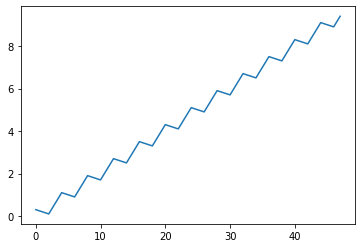

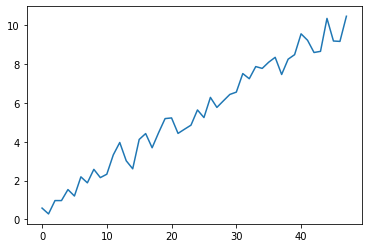

In [3]:
class SimpleDiscount(rcp.Lifted):
    def __call__(self, x, length, *args, **kwargs):
        return np.random.uniform(0, 0.7, size=length)  

class SimpleTarget(rcp.Lifted):

    def __call__(self, x, length, *args, **kwargs):
        trend = np.arange(length)  
        season = np.asarray([np.cos(2 * np.pi * i * 1/4) for i in range(length)])
        return 0.2 * trend + .3 * season

    
class SimpleElasticTarget(rcp.Lifted):

    def __call__(self, x, length, *args, **kwargs):
        trend = np.arange(length)  
        season = np.asarray([np.cos(2 * np.pi * i * 1/4) for i in range(length)])
        return 0.2 * trend + .3 * season + 2. * x
    
discounts = SimpleDiscount()(x=None, length=TIME_SERIE_LENGTH)  
    
plt.figure()
plt.plot(SimpleTarget()(x=None, length=TIME_SERIE_LENGTH))
plt.show()

plt.figure()
plt.plot(SimpleElasticTarget()(x=discounts, length=TIME_SERIE_LENGTH))
plt.show()


In [4]:
list_for_dataset = []
for _ in range(NUMBER_OF_TIME_SERIES):
    discounts = SimpleDiscount()(x=None, length=TIME_SERIE_LENGTH)
    sales = SimpleTarget()(x=None, length=TIME_SERIE_LENGTH)  
    list_for_dataset.append({
        "feat_dynamic_real": [discounts], 
        "target": sales, 
        "start": "2019-01-07 00:00"}
    )

simple_dataset = ListDataset(list_for_dataset, freq=META_DATA.freq)

In [5]:
list_for_dataset = []
for _ in range(NUMBER_OF_TIME_SERIES):
    discounts = SimpleDiscount()(x=None, length=TIME_SERIE_LENGTH)
    sales = SimpleElasticTarget()(x=discounts, length=TIME_SERIE_LENGTH)
    
    list_for_dataset.append({
        "feat_dynamic_real": [discounts], 
        "target": sales, 
        "start": "2019-01-07 00:00"}
    )

elastic_dataset = ListDataset(list_for_dataset, freq=META_DATA.freq)


In [6]:
def train_nbeats(estimator, dataset):
    predictor = estimator.train(dataset)
    forecast_it, ts_it = make_evaluation_predictions(
        dataset=dataset,  # test dataset
        predictor=predictor,  # predictor
        num_samples=NUM_SAMPLES,  # number of sample paths we want for evaluation
    )
    forecasts = list(forecast_it)
    tss = list(ts_it)
    evaluator = Evaluator()
    agg_metrics, item_metrics = evaluator(iter(tss), iter(forecasts), num_series=len(dataset))
    return agg_metrics["NRMSE"]


In [7]:
nbeats_estimator = NBEATSEstimator(
    freq=META_DATA.freq,
    prediction_length=META_DATA.prediction_length,
    context_length=META_DATA.prediction_length * 3,
    trainer=Trainer(device="cpu",
                    epochs=NUM_EPOCHS,
                    learning_rate=LEARNING_RATE,
                    num_batches_per_epoch=NUM_BATCHES_PER_EPOCH,
                    batch_size=BATCH_SIZE,
                    ),
    num_stacks=30,
    num_blocks=[1],
    num_block_layers=[4],
    stack_types=["G"],
    widths=[512],
    sharing=[False],
    expansion_coefficient_lengths=[32]
)

In [8]:
nbeats_X_estimator = NbeatsXEstimator(
    freq=META_DATA.freq,
    prediction_length=META_DATA.prediction_length,
    context_length=META_DATA.prediction_length * 3,
    trainer=Trainer(device="cpu",
                    epochs=NUM_EPOCHS,
                    learning_rate=LEARNING_RATE,
                    num_batches_per_epoch=NUM_BATCHES_PER_EPOCH,
                    batch_size=BATCH_SIZE,
                    ),
    num_stacks=30,
    num_blocks=[1],
    num_block_layers=[4],
    stack_types=["G"],
    widths=[512],
    sharing=[False],
    expansion_coefficient_lengths=[32]
)

## Nbeats X

In [9]:
train_nbeats(nbeats_X_estimator, elastic_dataset)

63it [00:00, 83.17it/s]
0it [00:08, ?it/s, avg_epoch_loss=6.68, epoch=0]
63it [00:00, 80.60it/s]
0it [00:08, ?it/s, avg_epoch_loss=3.24, epoch=1]
63it [00:01, 50.87it/s]
0it [00:07, ?it/s, avg_epoch_loss=2.92, epoch=2]
63it [00:00, 67.28it/s]
0it [00:08, ?it/s, avg_epoch_loss=3.04, epoch=3]
63it [00:01, 51.84it/s]
0it [00:09, ?it/s, avg_epoch_loss=2.69, epoch=4]
63it [00:01, 60.49it/s]
0it [00:08, ?it/s, avg_epoch_loss=3.88, epoch=5]
63it [00:01, 61.96it/s]
0it [00:09, ?it/s, avg_epoch_loss=4.19, epoch=6]
63it [00:00, 74.55it/s]
0it [00:08, ?it/s, avg_epoch_loss=161, epoch=7]
63it [00:00, 71.07it/s]
0it [00:10, ?it/s, avg_epoch_loss=4.62e+4, epoch=8]
63it [00:01, 60.21it/s]
0it [00:09, ?it/s, avg_epoch_loss=6.2e+4, epoch=9]
63it [00:00, 64.81it/s]
0it [00:09, ?it/s, avg_epoch_loss=1.01e+4, epoch=10]
63it [00:01, 58.40it/s]
0it [00:09, ?it/s, avg_epoch_loss=331, epoch=11]
63it [00:00, 91.13it/s] 
0it [00:07, ?it/s, avg_epoch_loss=8.55, epoch=12]
63it [00:00, 67.45it/s]
0it [00:09, ?it/s

0.01904966098286813

## Nbeats 

In [10]:
train_nbeats(nbeats_estimator, elastic_dataset)

63it [00:00, 116.24it/s]
0it [00:07, ?it/s, avg_epoch_loss=6.42, epoch=0]
63it [00:00, 114.98it/s]
0it [00:06, ?it/s, avg_epoch_loss=3.38, epoch=1]
63it [00:00, 103.25it/s]
0it [00:06, ?it/s, avg_epoch_loss=3.27, epoch=2]
63it [00:00, 100.66it/s]
0it [00:06, ?it/s, avg_epoch_loss=3.28, epoch=3]
63it [00:00, 88.71it/s]
0it [00:08, ?it/s, avg_epoch_loss=3.41, epoch=4]
63it [00:00, 78.12it/s]
0it [00:08, ?it/s, avg_epoch_loss=3.14, epoch=5]
63it [00:01, 41.88it/s]
0it [00:08, ?it/s, avg_epoch_loss=4.08, epoch=6]
63it [00:01, 55.47it/s]
0it [00:10, ?it/s, avg_epoch_loss=4.8, epoch=7]
63it [00:00, 118.75it/s]
0it [00:06, ?it/s, avg_epoch_loss=1.17e+4, epoch=8]
63it [00:00, 110.62it/s]
0it [00:07, ?it/s, avg_epoch_loss=4.55e+4, epoch=9]
63it [00:00, 93.55it/s]
0it [00:07, ?it/s, avg_epoch_loss=9.69e+3, epoch=10]
63it [00:00, 78.40it/s]
0it [00:11, ?it/s, avg_epoch_loss=346, epoch=11]
63it [00:00, 79.65it/s]
0it [00:08, ?it/s, avg_epoch_loss=96.3, epoch=12]
63it [00:00, 88.89it/s] 
0it [00:07

0.04886930590617455